In [1]:
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics

Matplotlib is building the font cache; this may take a moment.


In [2]:
from top_birds import competition_classes, score_threshold_file

2024-11-25 20:26:35.724730: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-25 20:26:37.060444: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-11-25 20:26:50.240346: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [3]:
x = pd.read_pickle('scores.pkl')[['primary_index','scores']]

In [4]:
def true_thresh(row):
    return row.scores[row.primary_index]

def tp_fp(row, thresh):
    idx, scores = row[['primary_index', 'scores']]
    is_on = scores >= thresh
    true_pos = int(is_on[idx])
    false_alarms = np.r_[is_on[:idx], is_on[idx+1:]].sum()
    return true_pos, false_alarms

def hit_false_alarm(row, thresh):
    hits, false_alarms = row.apply(lambda x: tp_fp(x, thresh), axis=1, result_type='expand').sum()
    return thresh, hits, false_alarms

In [5]:
thresholds_file = 'thresholds.pkl'
all_thresh = np.sort(np.array(x.apply(true_thresh, axis=1)))
if os.path.exists(thresholds_file):
    thresh_df = pd.read_pickle(thresholds_file)
else:
    thresh_df = pd.DataFrame([hit_false_alarm(x, thresh) for thresh in all_thresh],
                             columns=['threshold', 'hits', 'falsealarms'])
    thresh_df.to_pickle(thresholds_file)

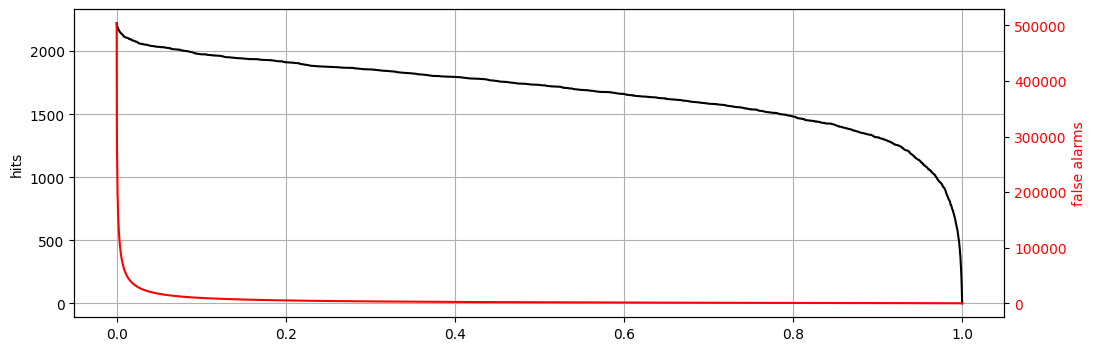

In [6]:
# https://www.statology.org/matplotlib-two-y-axes/
fig, axes = plt.subplots(1, 1, figsize=(12,4))
axes.plot(thresh_df['threshold'],thresh_df['hits'], 'k')
axes.set_ylabel('hits', color='k')
axes.grid()
axes2 = axes.twinx()
axes2.plot(thresh_df['threshold'],thresh_df['falsealarms'], 'r')
axes2.set_ylabel('false alarms', color='r')
axes2.tick_params(labelcolor='r')

In [7]:
def row_acc(row):
    return int(row.primary_index == row.scores.argmax())

In [8]:
x.apply(row_acc, axis=1).sum() / len(x)

0.7043204320432043

In [9]:
def roc_without_pos(neg_scores):
    def fp_without_pos(rate):
        return len(np.asarray(rate <= neg_scores).nonzero()[0]) / len(neg_scores)
    all_thresh = np.concatenate([[np.inf], sorted(set(neg_scores), reverse=True)])
    fpr = np.array([fp_without_pos(t) for t in all_thresh])
    tpr = None
    return fpr, tpr, all_thresh
    
def do_roc(id, target_fpr=.01):
    y_true = x['primary_index'] == id
    y_score = x['scores'].map(lambda x: x[id])
    num_pos = y_true.sum()
    if num_pos == 0:
        fpr, tpr, all_thresh = roc_without_pos(y_score)
    else:
        fpr, tpr, all_thresh = metrics.roc_curve(y_true, y_score, drop_intermediate=False)
    thresh_idx = np.asarray(fpr <= target_fpr ).nonzero()[0][-1]
    return {'n': num_pos,
            'fpr': fpr,
            'tpr': tpr,
            'all_thresh': all_thresh,
            'thresh_idx': thresh_idx,
            'thresh': all_thresh[thresh_idx],}

In [10]:
roc_dict = {idx: do_roc(idx, target_fpr=.001) for idx in range(264)}
median_thresh = np.median(np.array([roc['thresh'] for roc in roc_dict.values()]))
for idx in range(264):
    above_median_thresh = roc_dict[idx]['all_thresh'] >= median_thresh
    roc_dict[idx]['fpr_median_thresh'] = roc_dict[idx]['fpr'][above_median_thresh][-1]
pickle.dump(median_thresh, open(score_threshold_file, 'wb'))
median_thresh

0.7927436530590057

In [11]:
for idx, roc in roc_dict.items():
    thresh_idx = roc['thresh_idx']
    print(f"{idx:02} {roc['n']:02} {thresh_idx:02} {roc['thresh']:.04f}    {roc['fpr'][thresh_idx]:.03f} {roc['fpr_median_thresh']:.03f}", end='')
    if roc['tpr'] is not None:
        print(f"    {roc['tpr'][thresh_idx]:.03f}  ", end='')
    print('')

00 15 14 0.8849    0.001 0.002    0.800  
01 06 06 0.3042    0.001 0.000    0.667  
02 08 07 0.4351    0.001 0.000    0.625  
03 11 13 0.5486    0.001 0.000    1.000  
04 22 12 0.8656    0.001 0.002    0.455  
05 07 07 0.9690    0.001 0.001    0.714  
06 09 10 0.7956    0.001 0.001    0.889  
07 08 05 0.9454    0.001 0.003    0.375  
08 13 11 0.9068    0.001 0.003    0.692  
09 09 08 0.6830    0.001 0.000    0.667  
10 15 14 0.8459    0.001 0.001    0.800  
11 08 09 0.6615    0.001 0.000    0.875  
12 04 05 0.8710    0.001 0.001    0.750  
13 03 05 0.8994    0.001 0.001    1.000  
14 10 11 0.5289    0.001 0.000    0.900  
15 00 02 0.3667    0.001 0.000
16 09 04 0.9529    0.001 0.003    0.222  
17 15 12 0.8207    0.001 0.001    0.667  
18 13 13 0.5089    0.001 0.000    0.846  
19 12 08 0.9752    0.001 0.003    0.500  
20 08 08 0.8902    0.001 0.001    0.750  
21 09 09 0.4460    0.001 0.000    0.778  
22 17 17 0.8052    0.001 0.001    0.882  
23 05 05 0.7359    0.001 0.000    0.600  
24 

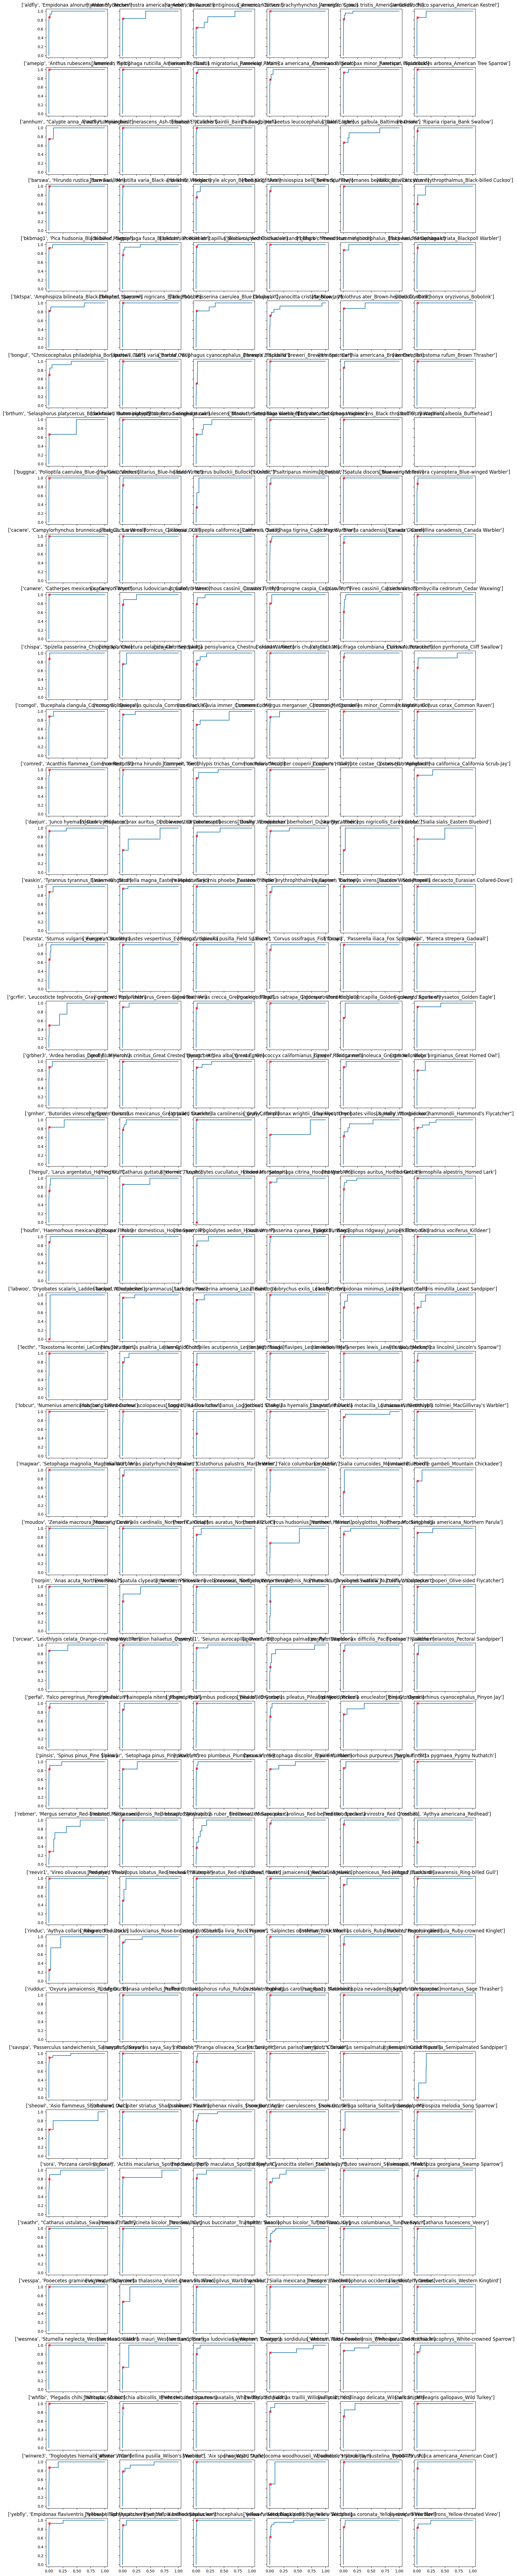

In [12]:
fig, axs = plt.subplots(264//6, 6, figsize=(20,120), sharex=True,sharey=True)
for idx, ax in enumerate( axs.flatten() ):
    roc = do_roc(idx)
    ax.set_title(competition_classes[idx])
    if roc['n'] > 0:
        fpr, tpr, thresh_idx = roc['fpr'], roc['tpr'], roc['thresh_idx']
        ax.plot(fpr, tpr)
        ax.plot(fpr[thresh_idx], tpr[thresh_idx], 'rx')
        ax.plot(fpr[thresh_idx+1], tpr[thresh_idx+1], 'r+')